## Setup

In [1]:
from collections import defaultdict
from glob import glob
import os
from typing import List, Dict
import yaml

from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import plotly.graph_objects as go

In [2]:
def get_color(idx, alpha):
    colors = [
        "rgba(99, 110, 250,",
        "rgba(239, 85, 59,",
        "rgba(0, 204, 150,",
        "rgba(171, 99, 250,",
        "rgba(255, 161, 90,",
        "rgba(25, 211, 243,",
        "rgba(255, 102, 146,",
        "rgba(182, 232, 128,",
        "rgba(255, 151, 255,",
        "rgba(254, 203, 82,",
    ]
    return colors[idx % len(colors)] + str(alpha) + ")"


def extract_scalar_values(logdir, metric_name):
    tensorboard_files = glob(os.path.join(logdir, "**", "events.*"))
    assert len(tensorboard_files) == 1, "More than one tensorboard file found"
    event_acc = event_accumulator.EventAccumulator(tensorboard_files[0])
    event_acc.Reload()
    return [event.value for event in event_acc.Scalars(metric_name)]


def plot_curves(curves, title=None, metric_name="Return"):
    learning_curve = go.Figure()
    for idx, (run_name, x_values, y_values, lower_bound, upper_bound) in enumerate(
        curves
    ):
        learning_curve.add_trace(
            go.Scatter(
                x=x_values,
                y=y_values,
                mode="lines",
                name=f"{run_name.split('/')[-1]}",
                line=dict(color=get_color(idx, 1)),
            )
        )
        learning_curve.add_trace(
            go.Scatter(
                x=x_values,
                y=lower_bound,
                fill=None,
                mode="lines",
                showlegend=False,
                line=dict(color=get_color(idx, 0.01)),
            )
        )
        learning_curve.add_trace(
            go.Scatter(
                x=x_values,
                y=upper_bound,
                fill="tonexty",
                mode="lines",
                showlegend=False,
                line=dict(color=get_color(idx, 0.01)),
            )
        )

    learning_curve.update_layout(
        title=title,
        xaxis_title="Step",
        yaxis_title=metric_name,
        legend=dict(x=0, y=1),
        template="plotly",
        width=800,
        height=500,
    )

    learning_curve.show()

## Select experiments

An *experiment* compares different *trials*, which have many *runs* (for each seed).

In [3]:
def get_trial_curves(trial_run_dirs, metric_name):
    values_list = [
        extract_scalar_values(run_dir, metric_name) for run_dir in trial_run_dirs
    ]
    max_length = max(len(values) for values in values_list)

    mean_values = np.array([])
    std_dev_values = np.array([])

    while len(mean_values) < max_length:
        processed = len(mean_values)
        section_length = min(
            len(values[processed:]) for values in values_list if len(values) > processed
        )
        section_means = np.mean(
            [
                values[processed : processed + section_length]
                for values in values_list
                if len(values) > processed
            ],
            axis=0,
        )
        section_std_devs = np.std(
            [
                values[processed : processed + section_length]
                for values in values_list
                if len(values) > processed
            ],
            axis=0,
        )
        mean_values = np.concatenate((mean_values, section_means))
        std_dev_values = np.concatenate((std_dev_values, section_std_devs))

    conf_int = 1.96 * (
        std_dev_values / np.sqrt(len(trial_run_dirs))
    )  # 95% confidence interval

    x_values = list(range(1, len(mean_values) + 1))
    y_values = mean_values
    lower_bound = mean_values - conf_int
    upper_bound = mean_values + conf_int

    return x_values, y_values, lower_bound, upper_bound


def get_trials_and_runs(
    experiment_name, config_queries: List[dict], key_to_compare: str, metric_name: str, debug=False
):
    trials = defaultdict(list)
    for config_file in glob("runs/*/configs.yaml"):
        with open(config_file, "r") as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
        
        if type(config_queries) is not list: config_queries = [config_queries]
        for config_query in config_queries:
            # perform an "or" operation between queries in the list
            for query_key, query_value in config_query.items():
                if config.get(query_key) != query_value:
                    break
            else:
                # add run to respective trial
                trials[config[key_to_compare]].append("runs/" + config["run_id"])
                if debug:
                    print(config[key_to_compare], config["run_id"], config)

    curves = []
    for trial_name, run_dirs in sorted(trials.items()):
        curves.append(
            (
                f"{trial_name} ({len(run_dirs)} seeds)",
                *get_trial_curves(run_dirs, metric_name),
            )
        )

    return plot_curves(
        curves,
        title=f"{experiment_name} {metric_name.split('/')[-1]}",
        metric_name=metric_name,
    )

def get_reward_and_success(*args, **kwargs):
    get_trials_and_runs(
        *args, **{
            **kwargs,
            "metric_name": "eval/mean_reward"
        }
    )
    get_trials_and_runs(
        *args, 
        **{
            **kwargs,
            "metric_name": "eval/success_rate"
        }
    )

## 2x2

In [4]:
get_reward_and_success(
    "2x2",
    [
        {
            "env_sparse_rewards": False,
            "env_shuffle_steps": 8,
            "env_win_reward": 10,
            "env_h": 2,
        },
        {
            "env_sparse_rewards": False,
            "env_shuffle_steps": 8,
            "env_win_reward": None,
            "env_h": 2,
        },
    ],
    "env_variation",
)

2024-01-29 15:39:48.329149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 15:39:49.134338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


./imgs/single 20240121-211511 {'env_h': 2, 'env_image_folder': './imgs/single', 'env_shuffle_steps': 8, 'env_sparse_rewards': False, 'env_variation': 'image', 'env_w': 2, 'n_envs': 32, 'n_steps': 1000, 'policy': 'CnnPolicy', 'run_id': '20240121-211511', 'seed': 304, 'total_timesteps': 1000000}
./imgs/imagenet-1k 20240121-211603 {'env_h': 2, 'env_image_folder': './imgs/imagenet-1k', 'env_shuffle_steps': 8, 'env_sparse_rewards': False, 'env_variation': 'image', 'env_w': 2, 'n_envs': 32, 'n_steps': 1000, 'policy': 'CnnPolicy', 'run_id': '20240121-211603', 'seed': 304, 'total_timesteps': 1000000}
./imgs/single 20240121-215723 {'env_h': 2, 'env_image_folder': './imgs/single', 'env_shuffle_steps': 8, 'env_sparse_rewards': False, 'env_variation': 'image', 'env_w': 2, 'n_envs': 32, 'n_steps': 1000, 'policy': 'CnnPolicy', 'run_id': '20240121-215723', 'seed': 420, 'total_timesteps': 1000000}
./imgs/single 20240121-224203 {'env_h': 2, 'env_image_folder': './imgs/single', 'env_shuffle_steps': 8, '

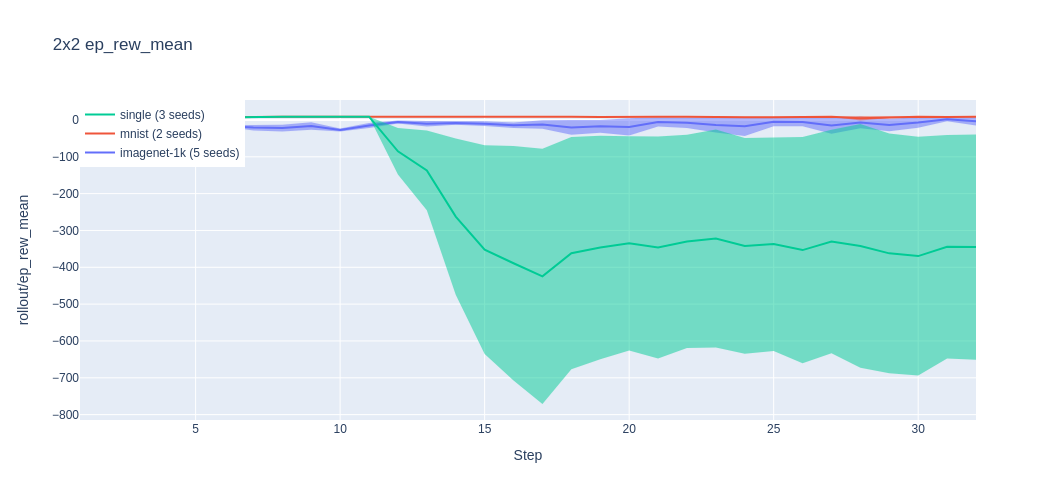

./imgs/single 20240121-211511 {'env_h': 2, 'env_image_folder': './imgs/single', 'env_shuffle_steps': 8, 'env_sparse_rewards': False, 'env_variation': 'image', 'env_w': 2, 'n_envs': 32, 'n_steps': 1000, 'policy': 'CnnPolicy', 'run_id': '20240121-211511', 'seed': 304, 'total_timesteps': 1000000}
./imgs/imagenet-1k 20240121-211603 {'env_h': 2, 'env_image_folder': './imgs/imagenet-1k', 'env_shuffle_steps': 8, 'env_sparse_rewards': False, 'env_variation': 'image', 'env_w': 2, 'n_envs': 32, 'n_steps': 1000, 'policy': 'CnnPolicy', 'run_id': '20240121-211603', 'seed': 304, 'total_timesteps': 1000000}
./imgs/single 20240121-215723 {'env_h': 2, 'env_image_folder': './imgs/single', 'env_shuffle_steps': 8, 'env_sparse_rewards': False, 'env_variation': 'image', 'env_w': 2, 'n_envs': 32, 'n_steps': 1000, 'policy': 'CnnPolicy', 'run_id': '20240121-215723', 'seed': 420, 'total_timesteps': 1000000}
./imgs/single 20240121-224203 {'env_h': 2, 'env_image_folder': './imgs/single', 'env_shuffle_steps': 8, '

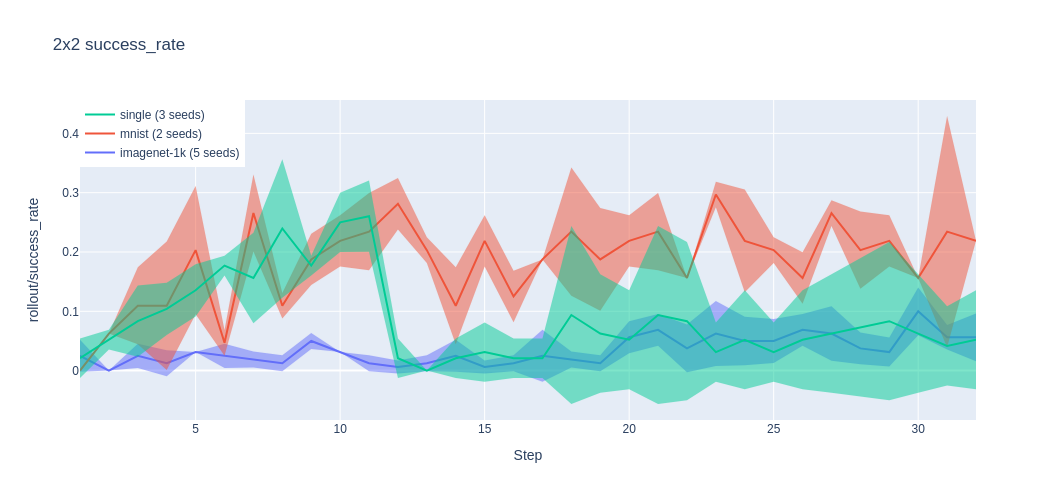

In [27]:
get_reward_and_success(
    "2x2",
    [
        {
            "env_sparse_rewards": False,
            "env_shuffle_steps": 8,
            "env_win_reward": 10,
            "env_h": 2,
            "env_variation": "image",
        },
        {
            "env_sparse_rewards": False,
            "env_shuffle_steps": 8,
            "env_win_reward": None,
            "env_h": 2,
            "env_variation": "image",
        },
    ],
    "env_image_folder",
)

## Raw Sparse vs Dense

In [8]:
get_reward_and_success(
    "Sparse",
    [
        {
            "env_sparse_rewards": True,
            "env_variation": "onehot",
            # "env_h": 5
        },
    ],
    "env_h",
)

In [15]:
get_reward_and_success(
    "Sparse",
    [
        {
            "env_sparse_rewards": True,
            "env_variation": "onehot",
            # "env_h": 5
        },
    ],
    "env_h",
)

In [5]:
get_reward_and_success(
    "Raw Sparse",
    [
        {
            "env_variation": "raw",
            "env_h": 2,
        },
    ],
    "env_sparse_rewards",
)

2024-01-27 16:31:12.176190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 16:31:13.117932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


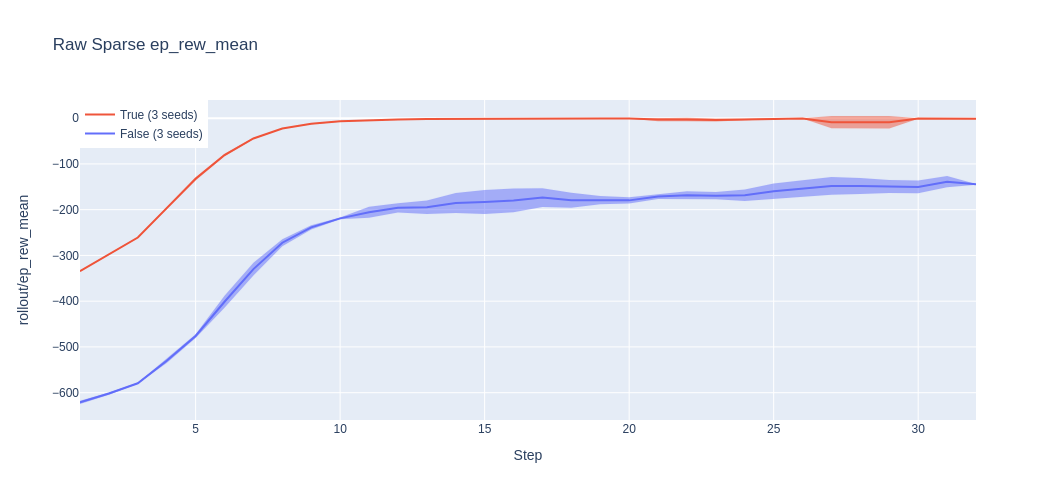

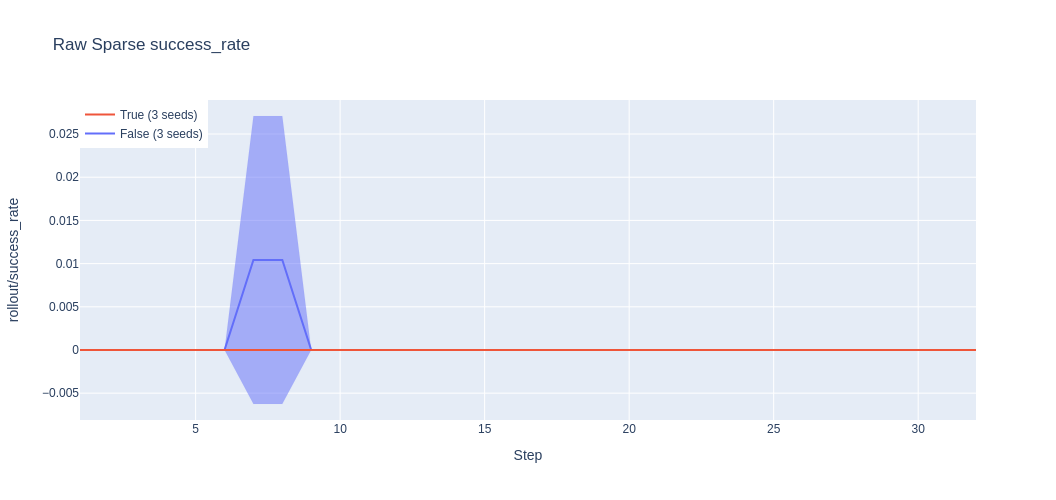

In [26]:
get_trials_and_runs(
    "Raw Sparse",
    [
        {
            "env_variation": "raw",
            "env_h": 3,
        },
    ],
    "env_sparse_rewards",
    "rollout/ep_rew_mean"
),
get_trials_and_runs(
    "Raw Sparse",
    [
        {
            "env_variation": "raw",
            "env_h": 3,
        },
    ],
    "env_sparse_rewards",
    "rollout/success_rate"
)

## Raw vs Onehot

In [6]:
get_reward_and_success(
    "Raw vs Onehot",
    [
        {
            "env_variation": "raw",
            "env_sparse_rewards": False,
            "env_h": 2,
        },
        {
            "env_variation": "normalized",
            "env_sparse_rewards": False,
            "env_h": 2,
        },
        {
            "env_variation": "onehot",
            "env_sparse_rewards": False,
            "env_h": 2,
        },
    ],
    "env_variation",
)

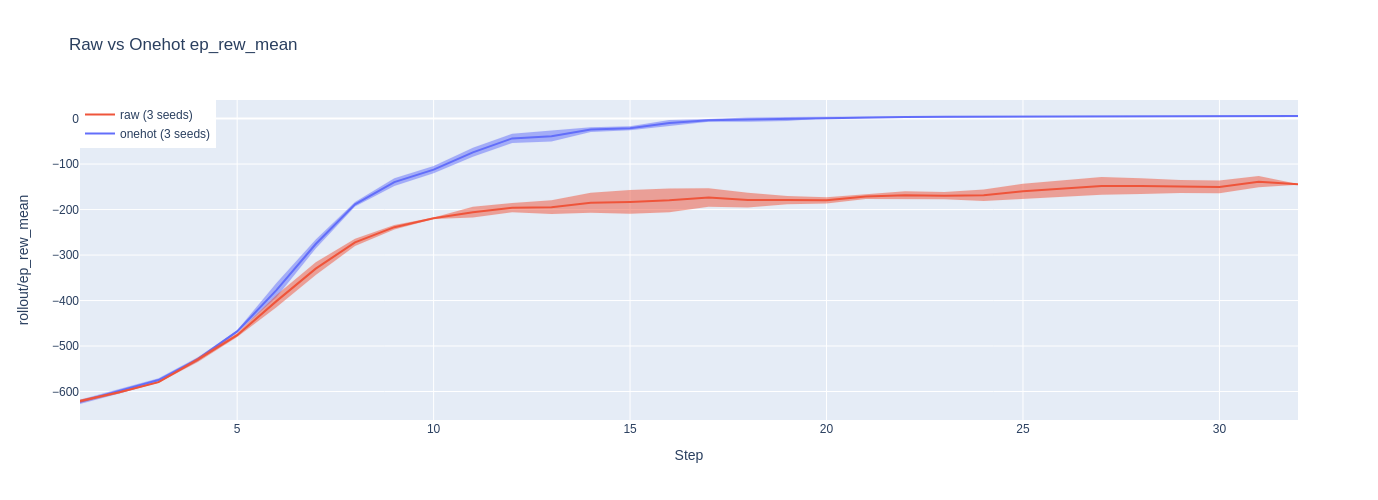

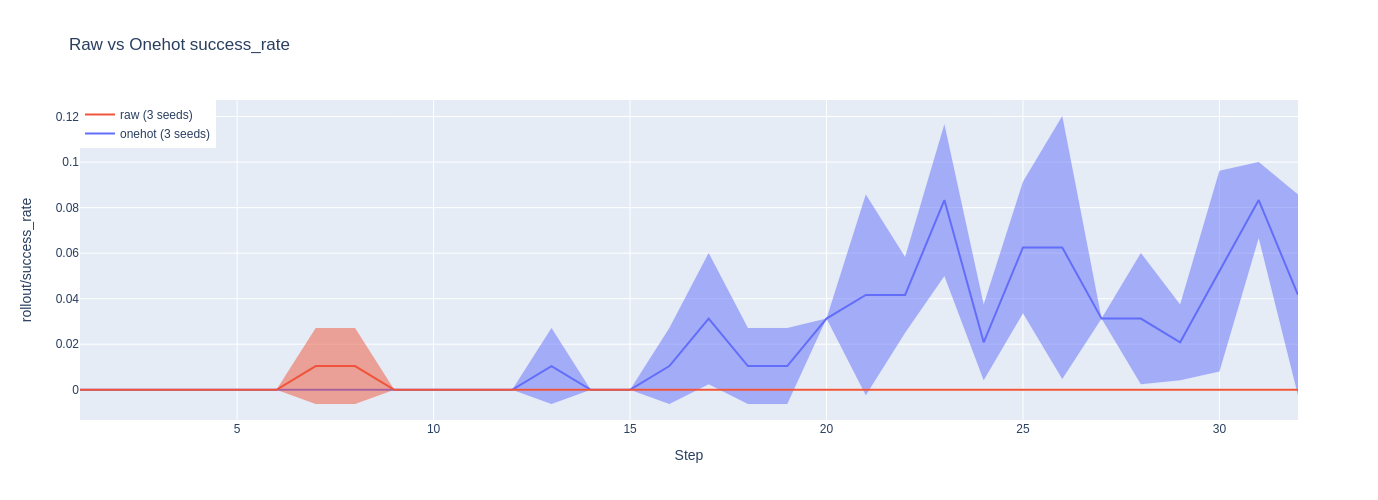

In [28]:
get_trials_and_runs(
    "Raw vs Onehot",
    [
        {
            "env_variation": "raw",
            "env_sparse_rewards": False,
            "env_h": 3,
        },
        {
            "env_variation": "onehot",
            "env_sparse_rewards": False,
            "env_h": 3,
        },
    ],
    "env_variation",
    "rollout/ep_rew_mean"
),
get_trials_and_runs(
    "Raw vs Onehot",
    [
        {
            "env_variation": "raw",
            "env_sparse_rewards": False,
            "env_h": 3,
        },
        {
            "env_variation": "onehot",
            "env_sparse_rewards": False,
            "env_h": 3,
        },
    ],
    "env_variation",
    "rollout/success_rate"
)

## Raw

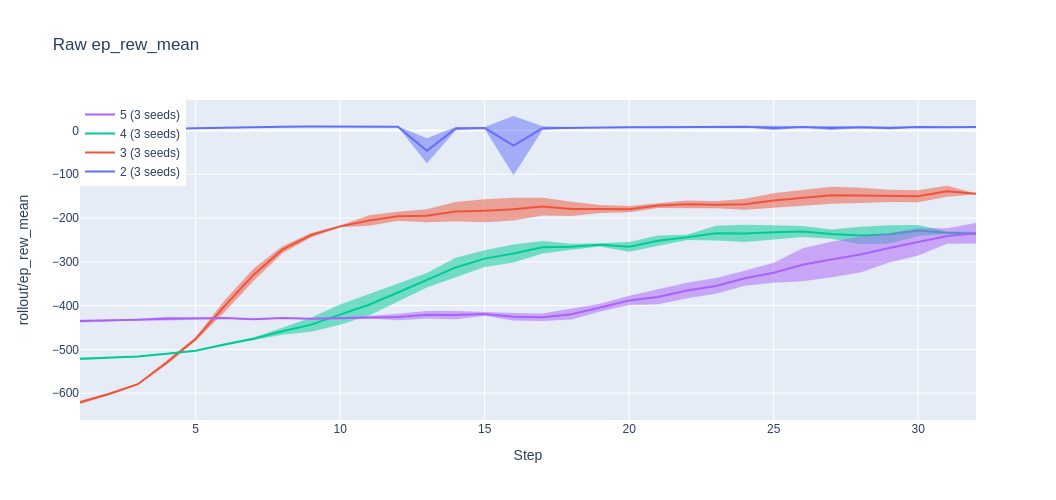

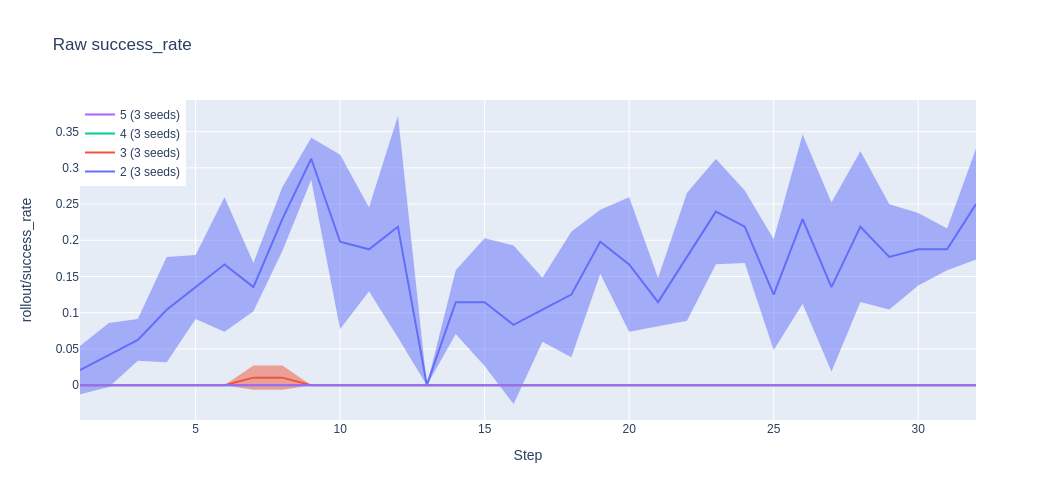

In [9]:
get_reward_and_success(
    "Raw",
    {
        "env_variation": "raw",
        "env_sparse_rewards": False,
    },
    "env_h",
)

## Normalized

In [8]:
get_reward_and_success(
    "Normalized",
    {
        "env_variation": "normalized",
        "env_sparse_rewards": False,
    },
    "env_h",
)

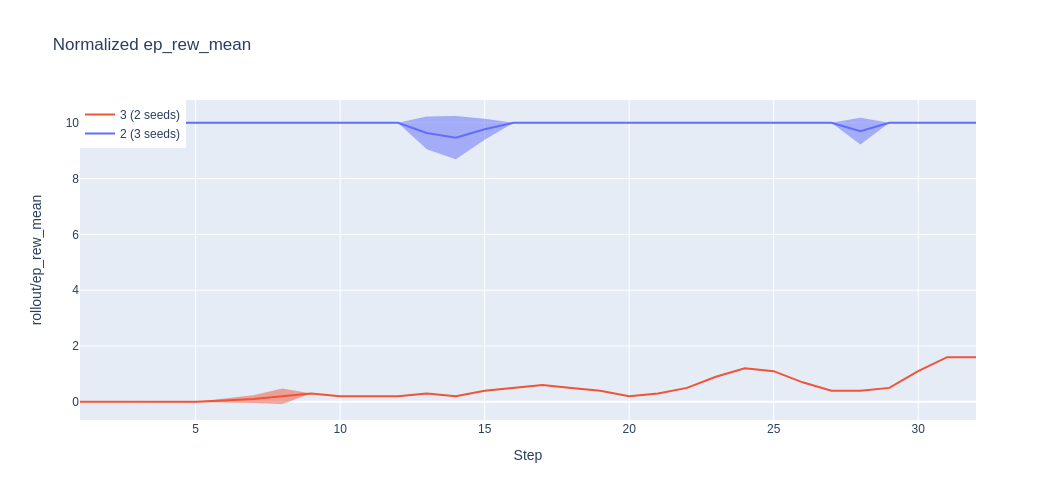

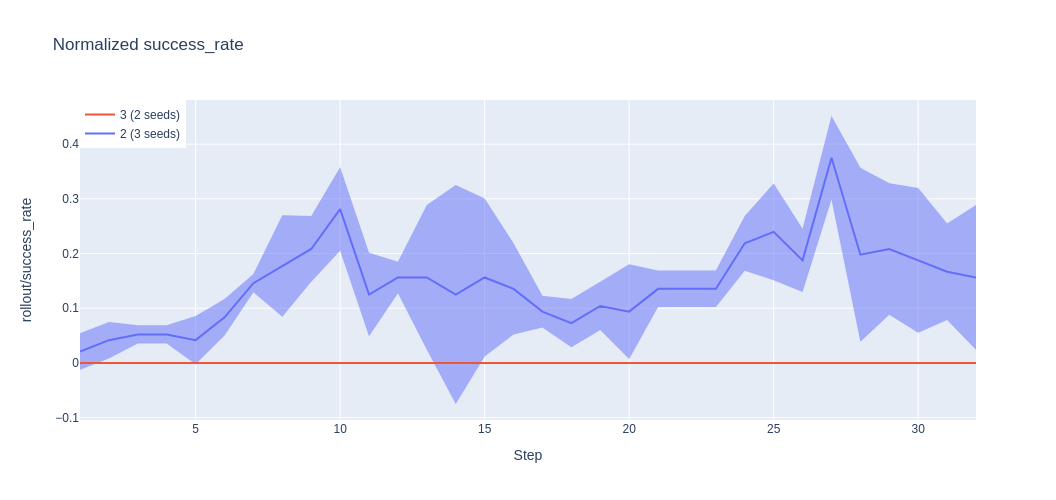

In [6]:
get_trials_and_runs(
    "Normalized",
    {
        "env_variation": "normalized",
        "env_sparse_rewards": True,
        "env_sparse_mode": "win",
    },
    "env_h",
    "rollout/ep_rew_mean"
),
get_trials_and_runs(
    "Normalized",
    {
        "env_variation": "normalized",
        "env_sparse_rewards": True,
        "env_sparse_mode": "win",
    },
    "env_h",
    "rollout/success_rate"
)

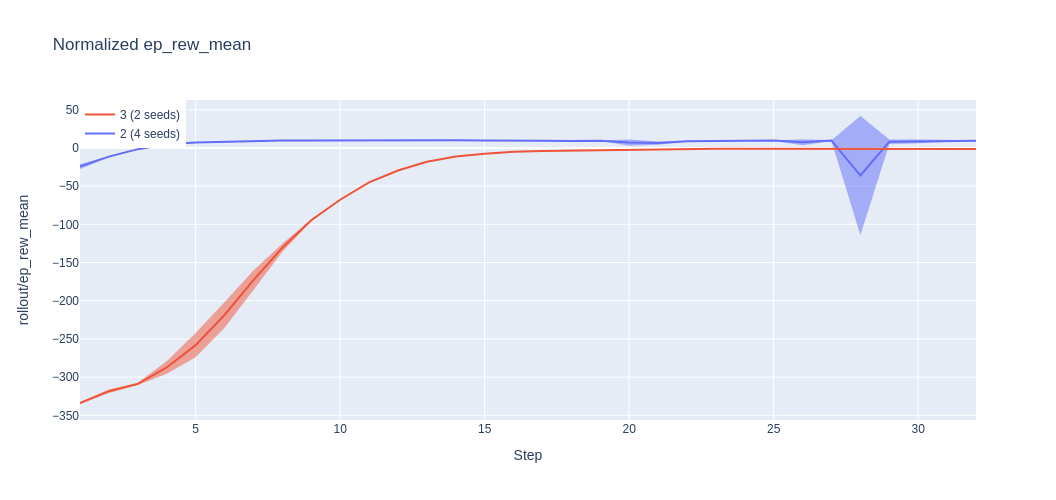

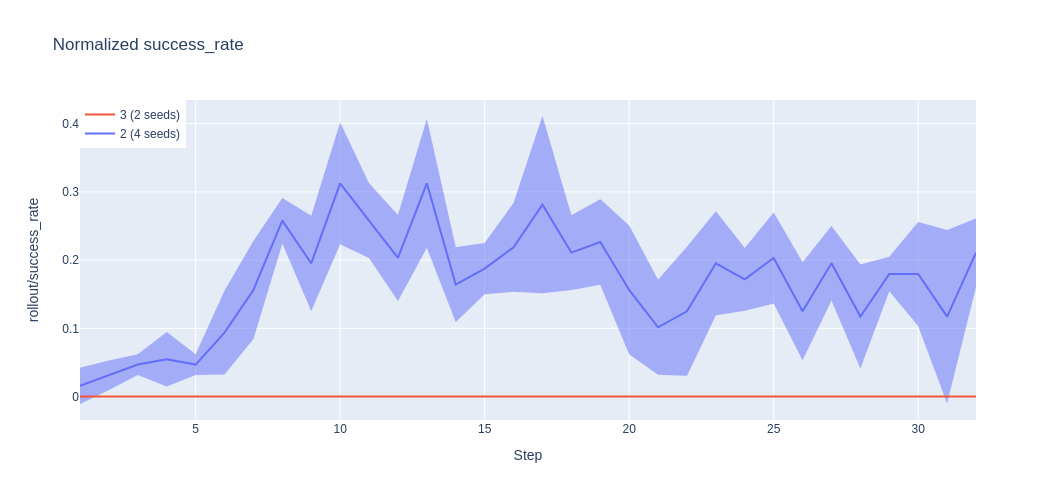

In [7]:
get_trials_and_runs(
    "Normalized",
    {
        "env_variation": "normalized",
        "env_sparse_rewards": True,
        "env_sparse_mode": "invalid_and_win",
    },
    "env_h",
    "rollout/ep_rew_mean"
),
get_trials_and_runs(
    "Normalized",
    {
        "env_variation": "normalized",
        "env_sparse_rewards": True,
        "env_sparse_mode": "invalid_and_win",
    },
    "env_h",
    "rollout/success_rate"
)

## Onehot

In [6]:
get_reward_and_success(
    "Onehot",
    {
        "env_variation": "onehot",
        "env_sparse_rewards": True,
    },
    "env_h",
)

In [7]:
get_reward_and_success(
    "Onehot",
    {
        "env_variation": "onehot",
        "env_sparse_rewards": False,
    },
    "env_h",
)

## Single Image

In [5]:
get_reward_and_success(
    "Single Image",
    {
        "policy": "CnnPolicy", 
        "env_variation": "image",
        "env_image_folder": "./imgs/single"
    },
    "env_h",
),

2024-01-29 09:59:19.888811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 09:59:20.743467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(None,)

## Mnist

In [6]:
get_reward_and_success(
    "Mnist",
    {
        "policy": "CnnPolicy", 
        "env_variation": "image",
        "env_image_folder": "./imgs/mnist"
    },
    "env_h"
),

(None,)

## Imagenet1k

In [8]:
get_reward_and_success(
    "Imagenet1k",
    {
        "policy": "CnnPolicy", 
        "env_variation": "image",
        "env_image_folder": "./imgs/imagenet-1k"
    },
    "env_h",
)